Loading data from: /Users/vutuyetvy/Downloads/emissions_final_processed.csv
Data loaded successfully
First 5 rows:
   year                   parent_entity         parent_type    commodity  \
0  1962  Abu Dhabi National Oil Company  State-owned Entity    Oil & NGL   
1  1962  Abu Dhabi National Oil Company  State-owned Entity  Natural Gas   
2  1963  Abu Dhabi National Oil Company  State-owned Entity    Oil & NGL   
3  1963  Abu Dhabi National Oil Company  State-owned Entity  Natural Gas   
4  1964  Abu Dhabi National Oil Company  State-owned Entity    Oil & NGL   

   production_value production_unit  total_emissions_MtCO2e  \
0           0.91250  Million bbl/yr                0.363885   
1           1.84325          Bcf/yr                0.134355   
2           1.82500  Million bbl/yr                0.727770   
3           4.42380          Bcf/yr                0.322453   
4           7.30000  Million bbl/yr                2.911079   

   emission_rate_per_unit  production_toe_MTOE  e

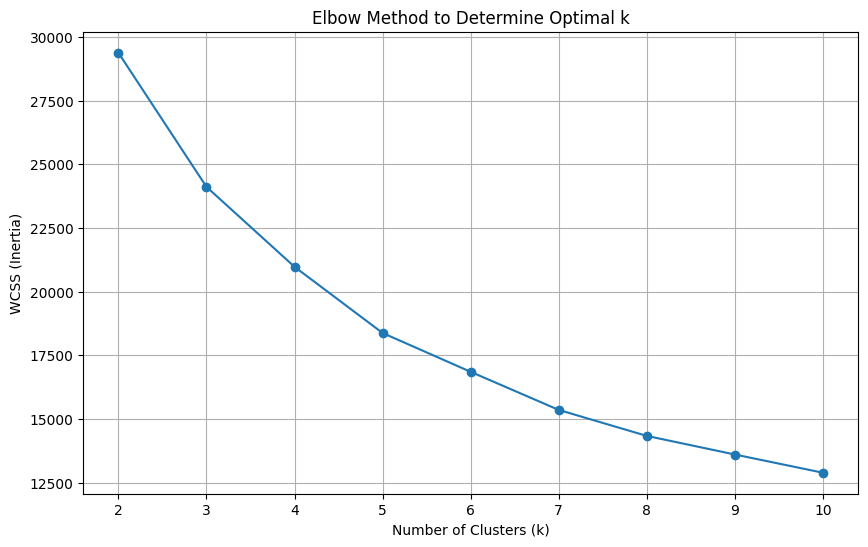

Optimal k selected: 7
Performing K-Means clustering with k=7...
Added 'Cluster' column to 10673 rows.
Cluster results saved to /Users/vutuyetvy/Downloads/clustering_results_k7.csv

--- Clustering Results (k=7) ---
First 10 rows:
   year  total_emissions_MtCO2e         parent_type    commodity  \
0  1962                0.363885  State-owned Entity    Oil & NGL   
1  1962                0.134355  State-owned Entity  Natural Gas   
2  1963                0.727770  State-owned Entity    Oil & NGL   
3  1963                0.322453  State-owned Entity  Natural Gas   
4  1964                2.911079  State-owned Entity    Oil & NGL   
5  1964                1.262939  State-owned Entity  Natural Gas   
6  1965                4.366618  State-owned Entity    Oil & NGL   
7  1965                1.827231  State-owned Entity  Natural Gas   
8  1966                5.385495  State-owned Entity    Oil & NGL   
9  1966                2.176554  State-owned Entity  Natural Gas   

                Countr

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import sys
import os

# === CONFIGURATION ===
FILE_PATH = '/Users/vutuyetvy/Downloads/emissions_final_processed.csv'
ELBOW_TABLE_FILENAME = '/Users/vutuyetvy/Downloads/elbow_method_comparison.csv'
RESULTS_FILENAME_PREFIX = 'clustering_results'
OUTPUT_DIRECTORY = '/Users/vutuyetvy/Downloads/'

numerical_features = ['total_emissions_MtCO2e']
categorical_features = ['parent_type', 'commodity', 'Country']
YEAR_COLUMN = 'year'
MIN_YEAR = 1960
K_RANGE = range(2, 11)

# === Load Data ===
print(f"Loading data from: {FILE_PATH}")
try:
    df = pd.read_csv(FILE_PATH)
    print("Data loaded successfully")
    print("First 5 rows:")
    print(df.head())
    print("\nData shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}")
    sys.exit("Check the file path and try again.")
except Exception as e:
    print(f"Error reading file: {e}")
    sys.exit("Could not read the data file.")

# === Check required columns ===
required_cols = [YEAR_COLUMN] + numerical_features + categorical_features
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"Error: Missing required columns: {missing_cols}")
    sys.exit("Missing necessary data columns.")

# === Filter data by year ===
if not pd.api.types.is_numeric_dtype(df[YEAR_COLUMN]):
    print(f"Warning: '{YEAR_COLUMN}' is not numeric. Attempting conversion...")
    try:
        df[YEAR_COLUMN] = pd.to_numeric(df[YEAR_COLUMN], errors='coerce')
        df.dropna(subset=[YEAR_COLUMN], inplace=True)
        df[YEAR_COLUMN] = df[YEAR_COLUMN].astype(int)
        print("Year column converted successfully.")
    except Exception as e:
        print(f"Error converting '{YEAR_COLUMN}': {e}")
        sys.exit("Invalid year data.")

df_filtered = df[df[YEAR_COLUMN] >= MIN_YEAR].copy()
if df_filtered.empty:
    print(f"Warning: No data found with {YEAR_COLUMN} >= {MIN_YEAR}.")
    sys.exit("No suitable data after filtering.")
print(f"Data filtered for {YEAR_COLUMN} >= {MIN_YEAR} ({len(df_filtered)} rows)")

# === Select features for clustering ===
features_for_clustering = numerical_features + categorical_features
df_cluster_input = df_filtered[features_for_clustering].copy()
print(f"Using features for clustering: {features_for_clustering}")

# === Data Preprocessing ===
print("Preprocessing data...")
for col in numerical_features:
    if df_cluster_input[col].isnull().any():
        median_val = df_cluster_input[col].median()
        df_cluster_input[col].fillna(median_val, inplace=True)
        print(f"Filled missing '{col}' with median ({median_val:.2f})")

for col in categorical_features:
    is_null = df_cluster_input[col].isnull().any()
    df_cluster_input[col] = df_cluster_input[col].astype(str)
    if is_null or (df_cluster_input[col] == 'nan').any():
        mode_val = df_cluster_input[col].mode()[0]
        df_cluster_input[col].replace('nan', mode_val, inplace=True)
        print(f"Filled missing '{col}' with mode ('{mode_val}')")

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

try:
    processed_data = preprocessor.fit_transform(df_cluster_input)
    print("Preprocessing complete.")
    print(f"Processed data shape: {processed_data.shape}")
except Exception as e:
    print(f"Preprocessing error: {e}")
    print("\nData types in input:")
    print(df_cluster_input.dtypes)
    sys.exit("Data preprocessing failed.")

# === Determine Optimal k using the Elbow Method ===
wcss = []
print("Calculating WCSS for Elbow Method...")
for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(processed_data)
    wcss.append(kmeans.inertia_)
    print(f"k={k}, WCSS={kmeans.inertia_:.2f}")

df_elbow = pd.DataFrame({'k': list(K_RANGE), 'WCSS_Inertia': wcss})
print("Elbow DataFrame:")
print(df_elbow.to_string())

try:
    os.makedirs(os.path.dirname(ELBOW_TABLE_FILENAME), exist_ok=True)
    df_elbow.to_csv(ELBOW_TABLE_FILENAME, index=False, encoding='utf-8-sig')
    print(f"Elbow table saved to {ELBOW_TABLE_FILENAME}")
except Exception as e:
    print(f"Error saving elbow table: {e}")

plt.figure(figsize=(10, 6))
plt.plot(df_elbow['k'], df_elbow['WCSS_Inertia'], marker='o', linestyle='-')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(df_elbow['k'])
plt.grid(True)
print("Displaying Elbow plot; close the plot window to continue.")
plt.show()

# === Get optimal k from user input ===
optimal_k = None
while optimal_k is None:
    try:
        optimal_k_input = input(f"Enter optimal k from the plot/table (e.g., {min(K_RANGE)}-{max(K_RANGE)-1}): ")
        optimal_k = int(optimal_k_input)
        if optimal_k < 2:
             print("Error: k must be at least 2.")
             optimal_k = None
    except ValueError:
        print("Error: Please enter a valid integer.")
print(f"Optimal k selected: {optimal_k}")

# === K-Means Clustering ===
print(f"Performing K-Means clustering with k={optimal_k}...")
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(processed_data)

df_results = df_filtered.copy()
if len(df_results) == len(cluster_labels):
    df_results['Cluster'] = cluster_labels
    print(f"Added 'Cluster' column to {len(df_results)} rows.")

    results_filename = os.path.join(OUTPUT_DIRECTORY, f"{RESULTS_FILENAME_PREFIX}_k{optimal_k}.csv")
    try:
        os.makedirs(os.path.dirname(results_filename), exist_ok=True)
        df_results.to_csv(results_filename, index=False, encoding='utf-8-sig')
        print(f"Cluster results saved to {results_filename}")
    except Exception as e:
        print(f"Error saving clustering results: {e}")
else:
    print("Error: Mismatch between the number of rows and cluster labels.")

# === Display Results and Cluster Summary ===
if 'Cluster' in df_results.columns:
    print(f"\n--- Clustering Results (k={optimal_k}) ---")
    display_cols = [YEAR_COLUMN] + features_for_clustering + ['Cluster']
    print("First 10 rows:")
    with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
        print(df_results[display_cols].head(10))
    print("Last 10 rows:")
    with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
        print(df_results[display_cols].tail(10))

    print(f"\n--- Cluster Summary (k={optimal_k}) ---")
    print("Average 'total_emissions_MtCO2e' per cluster:")
    try:
        cluster_summary_numerical = df_results.groupby('Cluster')[numerical_features].mean()
        print(cluster_summary_numerical)
    except Exception as e:
         print(f"Error in numerical summary: {e}")

    print("\nDistribution of 'commodity' per cluster:")
    try:
        cluster_summary_categorical = df_results.groupby('Cluster')['commodity'].value_counts().unstack(fill_value=0)
        with pd.option_context('display.max_rows', 10, 'display.max_columns', 10):
            print(cluster_summary_categorical)
    except Exception as e:
        print(f"Error in commodity summary: {e}")

    print("\nDistribution of 'Country' per cluster:")
    try:
        cluster_summary_country = df_results.groupby('Cluster')['Country'].value_counts().unstack(fill_value=0)
        with pd.option_context('display.max_rows', 10, 'display.max_columns', 10):
            print(cluster_summary_country)
    except Exception as e:
        print(f"Error in country summary: {e}")

print("\n--- Process completed ---")